In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
credits = pd.read_csv('../dataset/credits.csv')
keywords = pd.read_csv('../dataset/keywords.csv')
links = pd.read_csv('../dataset/links_small.csv')
md = pd.read_csv('../dataset/movies_metadata.csv')
ratings = pd.read_csv('../dataset/ratings_small.csv')

/var/folders/wy/xyqwny610cb9ft3dhglx4jyc0000gn/T/ipykernel_21698/949808799.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('../dataset/movies_metadata.csv')


ratings

In [4]:
user_movie_df = ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating how much of the user_move matrix is null:

In [6]:
((user_movie_df.isnull().sum().sum()) / (user_movie_df.shape[0] * user_movie_df.shape[1])) * 100

98.35608583913366

### Check box/hist of movie rated numbers:

<Axes: >

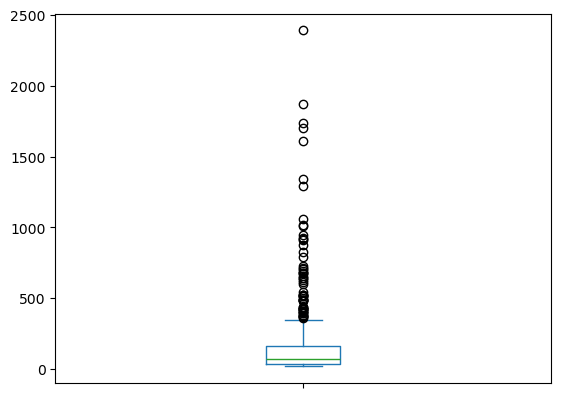

In [8]:
user_movie_df.count(axis=1).plot.box()

<Axes: ylabel='Frequency'>

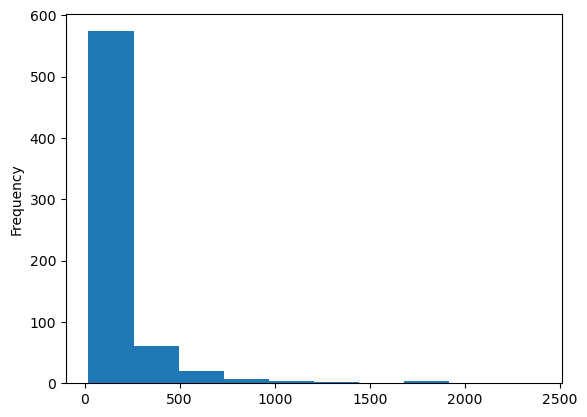

In [9]:
user_movie_df.count(axis=1).plot.hist()

### User2User CF
1. Calculate similarity matrix (pearson or cosine)
2. knn for each user
3. combine ratings to predict a rating

In [11]:
# Pearson:
user_distances = user_movie_df.transpose().corr(method='pearson')

# Cosine:
# user_similarity = cosine_similarity(user_distances.to_numpy())

Set n neighbors to 5 for now:

In [13]:
nneighbors = 5

user_distances = user_distances.dropna(axis=0, thresh=nneighbors+1).dropna(axis=1, 
                                                                           thresh=nneighbors+1)
# Make the matrix square (dropping the extra rows as well)
user_distances = user_distances.loc[user_distances.columns]

user_distances = 1.0 - user_distances

In [24]:
# WHY TF
user_distances[user_distances < 0] = 0

In [60]:
model_knn = NearestNeighbors(metric='precomputed', 
                             algorithm='brute', n_neighbors=nneighbors, n_jobs=-1)

model_knn.fit(csr_matrix(user_distances.fillna(0).values))

similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values), 
                                           n_neighbors=nneighbors)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [62]:
similarity.shape

(671, 5)

In [64]:
indexes

array([[311, 241,  34, 389, 504],
       [593, 491, 179, 322, 342],
       [339, 511, 444, 317,  10],
       ...,
       [518, 455,   2, 148, 234],
       [214, 617, 527, 255, 428],
       [206, 444, 268, 539, 195]], dtype=int32)

In [66]:
similarity

array([[8.16340187e-03, 2.92746566e-02, 7.14285714e-02, 7.28273501e-02,
        1.29611720e-01],
       [1.11022302e-16, 1.80194939e-02, 2.92746566e-02, 5.50888175e-02,
        5.50888175e-02],
       [2.22044605e-16, 2.22044605e-16, 3.88350982e-03, 1.80194939e-02,
        2.89392389e-02],
       ...,
       [1.11022302e-16, 3.33066907e-16, 2.92746566e-02, 3.16703363e-02,
        5.50888175e-02],
       [2.22044605e-16, 2.22044605e-16, 1.52680722e-02, 3.16703363e-02,
        3.92310772e-02],
       [3.33066907e-16, 3.33066907e-16, 3.92310772e-02, 6.67434747e-02,
        8.82352941e-02]])

In [84]:
neighborhoods = pd.DataFrame({'neighborhood_ids':[user_distances.iloc[neighbors].index.to_list() 
                                                for neighbors in indexes], 
                              'distance': similarity.tolist()}, 
                             index=user_distances.index)
neighborhoods

,neighborhood_ids,distance
userId,,
1,"[312, 242, 35, 390, 505]","[0.008163401865824538, 0.029274656605848826, 0..."
2,"[594, 492, 180, 323, 343]","[1.1102230246251565e-16, 0.01801949393803437, ..."
3,"[340, 512, 445, 318, 11]","[2.220446049250313e-16, 2.220446049250313e-16,..."
4,"[156, 499, 404, 653, 280]","[0.027553511028476585, 0.07173262048650408, 0...."
5,"[364, 398, 106, 127, 348]","[0.02020410288672858, 0.05508881747693195, 0.0..."
...,...,...
667,"[164, 378, 473, 660, 277]","[1.1102230246251565e-16, 1.1102230246251565e-1..."
668,"[110, 487, 578, 189, 271]","[2.220446049250313e-16, 2.220446049250313e-16,..."
669,"[519, 456, 3, 149, 235]","[1.1102230246251565e-16, 3.3306690738754696e-1..."


In [86]:
neighbors = neighborhoods['neighborhood_ids'].loc[1]
neighbors

[312, 242, 35, 390, 505]

In [104]:
user_movie_df.loc[neighbors].mean().dropna().sort_values()[-10:]

movieId
2501     5.0
2570     5.0
2598     5.0
2616     5.0
2692     5.0
2757     5.0
2764     5.0
2802     5.0
1952     5.0
86882    5.0
dtype: float64

## All of them with each other

In [107]:
def usercf_predict_rating_closure(user_ratings, neighborhoods):
    def usercf_predict_rating_using_nmean(row):
        neighbors_ids = neighborhoods['neighborhood_ids'].loc[row.name]
        pred_ratings = user_movie_df.loc[neighbors_ids].mean()
        return round(pred_ratings)
    
    return usercf_predict_rating_using_nmean

In [121]:
def recommendation_system_user_model(minperiods, nneighbors, user_ratings):
    user_distances = user_ratings.transpose().corr(method='pearson', 
                                                   min_periods=minperiods)
    
    user_distances = user_distances.dropna(axis=0, 
                                           thresh=nneighbors+1).dropna(axis=1, 
                                                                       thresh=nneighbors+1)
    user_distances = user_distances.loc[user_distances.columns]
    
    user_distances = 1 - user_distances
    
    user_distances[user_distances < 0] = 0

    model_knn = NearestNeighbors(metric='precomputed', algorithm='brute', 
                                 n_neighbors=nneighbors, n_jobs=-1)

    model_knn.fit(csr_matrix(user_distances.fillna(0).values))
    
    similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values), 
                                               n_neighbors=nneighbors)
    neighborhoods = pd.DataFrame({'neighborhood_ids':
                                  [user_distances.iloc[neighbors].index.to_list() 
                                                    for neighbors in indexes], 
                                  'distance': similarity.tolist()}, 
                                 index=user_distances.index)
    
    pred = user_ratings.reindex(neighborhoods.index).apply(usercf_predict_rating_closure(user_ratings, 
                                                                                        neighborhoods), 
                                                           axis='columns')
    # user_ratings.merge(pred, how='right')
    return pred, neighborhoods

In [123]:
def mae(user_ratings, predicted_ratings):
    abs_dif = abs(user_ratings - predicted_ratings)
    n = np.sum(user_ratings.count()) 
    return abs_dif.sum().sum()/ n

In [125]:
a, b = recommendation_system_user_model(5, 10, user_movie_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [141]:
a

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,2.0,NaN,NaN,4.0,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,3.0,3.0,2.0,NaN,NaN,5.0,NaN,1.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,4.0,4.0,2.0,3.0,4.0,NaN,5.0,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
a.loc[100].sort_values(ascending=False)[:10]

movieId
527      5.0
3510     5.0
111      5.0
52885    5.0
4277     5.0
1269     5.0
53956    5.0
4308     5.0
5618     5.0
2087     5.0
Name: 100, dtype: float64

In [185]:
movie_ids = a.loc[100].sort_values(ascending=False)[:10].index
movie_ids

Index([527, 3510, 111, 52885, 4277, 1269, 53956, 4308, 5618, 2087], dtype='int64', name='movieId')

In [215]:
md[md['id'].isin(map(str, movie_ids))]['title'].tolist()

['Once Were Warriors',
 'The Getaway',
 'Scarface',
 'Cousin, Cousine',
 'The Red and the White',
 'The Vexxer']